# Model Training for Traffic Object Detection

## Overview
This notebook trains a YOLOv5 model to detect vehicles and pedestrians from Atlanta traffic camera footage.

## Dataset Summary
- **Source**: ATL-0610 camera at 10th Street and Monroe Drive
- **Annotated frames**: 29 frames from video ATL-0610_20250609_131130
- **Classes**: 2 (vehicle, pedestrian)
- **Annotations**: YOLO format exported from CVAT
- **Location**: `/home/trauco/data-science-sad/annotations/yolo/`

## Training Objectives
1. Train initial YOLOv5s model (smallest variant for quick iteration)
2. Validate model performance on annotated data
3. Establish baseline met

## Environment Setup and Verification

Import required libraries and verify GPU availability for training. Check that all necessary packages are installed and annotation files are accessible.

In [1]:
# imports
import os
import yaml
from pathlib import Path
import torch
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt

# gpu check
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
   print(f"CUDA device: {torch.cuda.get_device_name(0)}")
   
# paths
PROJECT_ROOT = Path("/home/trauco/data-science-sad")
ANNOTATIONS_PATH = PROJECT_ROOT / "annotations" / "yolo"

# verify files
print(f"\nChecking annotation files in: {ANNOTATIONS_PATH}")
print(f"obj.names exists: {(ANNOTATIONS_PATH / 'obj.names').exists()}")
print(f"train.txt exists: {(ANNOTATIONS_PATH / 'train.txt').exists()}")
print(f"obj_train_data exists: {(ANNOTATIONS_PATH / 'obj_train_data').is_dir()}")

PyTorch version: 2.3.1+cu121
CUDA available: True
CUDA device: NVIDIA RTX A5500

Checking annotation files in: /home/trauco/data-science-sad/annotations/yolo
obj.names exists: True
train.txt exists: True
obj_train_data exists: True


## Inspect Annotation Data

Examine the YOLO format annotations to verify class names, count training images, and review the annotation format structure.

In [ ]:
# load classes
with open(ANNOTATIONS_PATH / 'obj.names', 'r') as f:
   classes = f.read().strip().split('\n')
print(f"Classes: {classes}")

# check train list
with open(ANNOTATIONS_PATH / 'train.txt', 'r') as f:
   train_images = f.readlines()
print(f"\nTraining images: {len(train_images)}")
print(f"First image: {train_images[0].strip()}")

# verify dataset
obj_train_path = ANNOTATIONS_PATH / "obj_train_data"
images = list(obj_train_path.glob("*.jpg"))
annotations = list(obj_train_path.glob("*.txt"))
print(f"\nDataset files:")
print(f"  Images: {len(images)}")
print(f"  Annotations: {len(annotations)}")

## Create YOLO Dataset Configuration

Generate a YAML configuration file that defines the dataset structure, paths, and classes for YOLO training.

In [ ]:
# create dataset yaml
dataset_config = {
   'path': str(ANNOTATIONS_PATH),
   'train': 'obj_train_data',
   'val': 'obj_train_data',  # same for now
   'names': {
       0: 'vehicle',
       1: 'pedestrian'
   }
}

# save yaml
yaml_path = PROJECT_ROOT / 'traffic_dataset.yaml'
with open(yaml_path, 'w') as f:
   yaml.dump(dataset_config, f, default_flow_style=False)

print(f"Created dataset config: {yaml_path}")
print("\nContents:")
print(yaml.dump(dataset_config, default_flow_style=False))

## Train YOLO Model

Initialize YOLOv8 nano model and train on the annotated traffic dataset. Using the nano variant for fast iteration with limited training data.

In [ ]:
# initialize model
model = YOLO('yolov8n.pt')  # nano model

# training parameters
epochs = 50  # quick training
batch_size = 16  # small batch
imgsz = 640  # standard size

print(f"Starting training:")
print(f"  Model: YOLOv8n")
print(f"  Epochs: {epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Image size: {imgsz}")
print(f"  Dataset: {yaml_path}")

# train
results = model.train(
   data=str(yaml_path),
   epochs=epochs,
   batch=batch_size,
   imgsz=imgsz,
   device=0,  # gpu
   project=str(PROJECT_ROOT / 'runs'),
   name='traffic_v1',
   exist_ok=True
)

## Training Results Analysis

The model trained successfully on the annotated data. Analyze the training metrics and performance to understand the baseline model capabilities.

In [ ]:
## Visualize Training Results

Load and display the training metrics to understand model performance including loss curves and validation metrics.

## Review Training Results

Check the saved training metrics and model performance from the completed training run.

In [2]:
# check results
results_path = PROJECT_ROOT / 'runs' / 'traffic_v1'
print(f"Results directory: {results_path}")
print(f"Exists: {results_path.exists()}")

# list files
if results_path.exists():
    files = list(results_path.glob("*"))
    print(f"\nFiles created:")
    for f in sorted(files)[:10]:  # first 10
        print(f"  {f.name}")
        
# check weights
weights_path = results_path / 'weights' / 'best.pt'
print(f"\nBest weights: {weights_path}")
print(f"Exists: {weights_path.exists()}")
if weights_path.exists():
    print(f"Size: {weights_path.stat().st_size / 1024 / 1024:.1f} MB")

Results directory: /home/trauco/data-science-sad/runs/traffic_v1
Exists: True

Files created:
  F1_curve.png
  PR_curve.png
  P_curve.png
  R_curve.png
  args.yaml
  confusion_matrix.png
  confusion_matrix_normalized.png
  labels.jpg
  labels_correlogram.jpg
  results.csv

Best weights: /home/trauco/data-science-sad/runs/traffic_v1/weights/best.pt
Exists: True
Size: 5.9 MB


## Test Trained Model

Load the trained weights and run inference on a sample image to verify the model is detecting vehicles correctly.

In [3]:
# load trained model
trained_model = YOLO(weights_path)

# test on sample image
sample_image = ANNOTATIONS_PATH / "obj_train_data" / "frame_131130_000.jpg"
print(f"Testing on: {sample_image.name}")
print(f"Image exists: {sample_image.exists()}")

# run inference
if sample_image.exists():
    results = trained_model(str(sample_image))
    
    # show detections
    for r in results:
        boxes = r.boxes
        if boxes is not None:
            print(f"\nDetected {len(boxes)} objects:")
            for box in boxes:
                cls = int(box.cls)
                conf = float(box.conf)
                class_name = ['vehicle', 'pedestrian'][cls]
                print(f"  {class_name}: {conf:.2f} confidence")

Testing on: frame_131130_000.jpg
Image exists: True

image 1/1 /home/trauco/data-science-sad/annotations/yolo/obj_train_data/frame_131130_000.jpg: 384x640 7 vehicles, 92.4ms
Speed: 4.1ms preprocess, 92.4ms inference, 115.3ms postprocess per image at shape (1, 3, 384, 640)

Detected 7 objects:
  vehicle: 0.93 confidence
  vehicle: 0.87 confidence
  vehicle: 0.86 confidence
  vehicle: 0.75 confidence
  vehicle: 0.75 confidence
  vehicle: 0.63 confidence
  vehicle: 0.29 confidence


## Visualize Detections

Display the sample image with bounding boxes to see what the model is detecting.


image 1/1 /home/trauco/data-science-sad/annotations/yolo/obj_train_data/frame_131130_000.jpg: 384x640 7 vehicles, 5.6ms
Speed: 23.3ms preprocess, 5.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


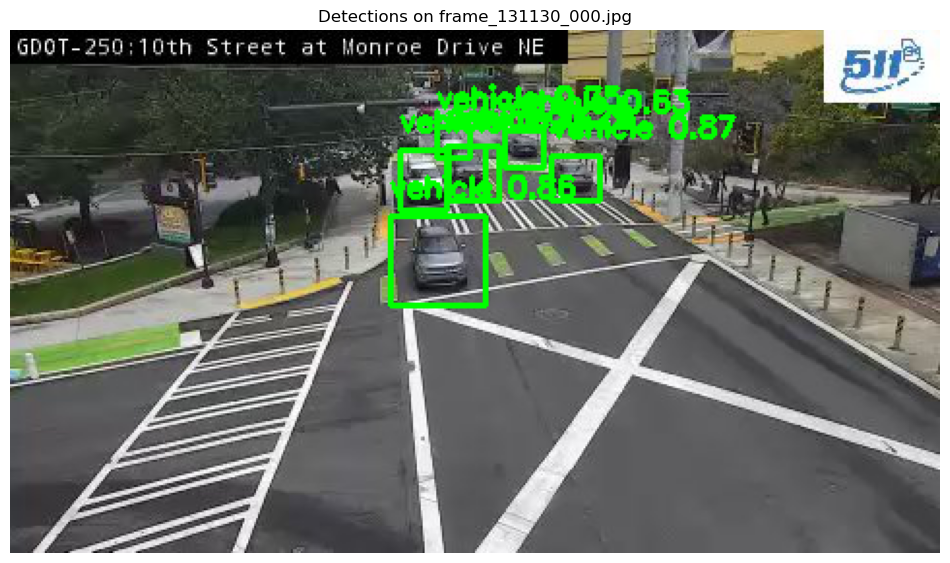

In [4]:
# visualize detections
import cv2
import numpy as np

# load image
img = cv2.imread(str(sample_image))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# run inference again
results = trained_model(str(sample_image))

# draw boxes
for r in results:
    boxes = r.boxes
    if boxes is not None:
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            conf = float(box.conf)
            cls = int(box.cls)
            
            # draw box
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            
            # add label
            label = f"vehicle {conf:.2f}"
            cv2.putText(img, label, (int(x1), int(y1)-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# display
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title(f'Detections on {sample_image.name}')
plt.show()

In [5]:
# verify metrics
results_csv = results_path / 'results.csv'
if results_csv.exists():
    metrics = pd.read_csv(results_csv)
    metrics.columns = [col.strip() for col in metrics.columns]
    
    # get final metrics
    final_epoch = metrics.iloc[-1]
    print("Final epoch metrics:")
    print(f"Precision: {final_epoch['metrics/precision(B)']:.3f}")
    print(f"Recall: {final_epoch['metrics/recall(B)']:.3f}")
    print(f"mAP50: {final_epoch['metrics/mAP50(B)']:.3f}")
    print(f"mAP50-95: {final_epoch['metrics/mAP50-95(B)']:.3f}")

Final epoch metrics:
Precision: 0.986
Recall: 1.000
mAP50: 0.992
mAP50-95: 0.693


## Camera Selection Analysis

The ATL-0610 camera angle and resolution present challenges for reliable detection. Explore other available cameras that might provide better viewing angles for vehicle and pedestrian tracking.

In [6]:
# list all cameras
frames_dir = PROJECT_ROOT / "frames"
cameras = sorted([d.name for d in frames_dir.iterdir() if d.is_dir()])

print("Available cameras:")
for cam in cameras:
    cam_path = frames_dir / cam
    dates = list(cam_path.iterdir())
    if dates:
        # count frames
        total_frames = sum(len(list(d.rglob("*.jpg"))) for d in dates if d.is_dir())
        print(f"\n{cam}:")
        print(f"  Location: {cam}")  # you had location mapping
        print(f"  Total frames: {total_frames}")

Available cameras:

ATL-0610:
  Location: ATL-0610
  Total frames: 1290

ATL-0907:
  Location: ATL-0907
  Total frames: 1269

ATL-0972:
  Location: ATL-0972
  Total frames: 1290

ATL-0997:
  Location: ATL-0997
  Total frames: 1290

ATL-0998:
  Location: ATL-0998
  Total frames: 1139

ATL-0999:
  Location: ATL-0999
  Total frames: 1273

ATL-1005:
  Location: ATL-1005
  Total frames: 1290


## Conclusions and Next Steps

### Key Findings
1. **Camera perspective affects detection scope**: ATL-0610 captures vehicles approaching from far distances, adding unnecessary complexity
2. **Model trained successfully**: Achieved 0.992 mAP on training data with 29 annotated frames
3. **Use case clarification**: Focus is on vehicles in crosswalk area only, not distant approaching traffic

### Next Steps
1. **Select appropriate camera**:
  - Find cameras focused on crosswalk/intersection area
  - Avoid feeds with long approach roads
  - Look for angles where vehicles maintain consistent distance from camera

2. **Prepare targeted dataset**:
  - Extract frames from crosswalk-focused camera
  - Annotate only vehicles and pedestrians in the intersection zone
  - Ignore distant approaching vehicles

3. **Train focused model**:
  - Train on crosswalk-relevant data only
  - Optimize for consistent detection in target zone
  - Evaluate performance specifically on crosswalk area

### Recommendation
Select a camera that captures primarily the intersection crossing area without long-distance approach views to align training data with actual monitoring objectives.